<a href="https://colab.research.google.com/github/tannguyen2512/CS_week2_project_scrape_Tiki_categories_products/blob/master/WeeklyProject_Get_Tiki_main_categories_sub_categories.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Guidelines

This weekly project might be a little tougher than usual, as you have to have a clear workflow and how to organize your functions. So here is an example workflow you can follow:

- Step 1: Build and fill your Category table using example code in the notebook

- Step 2: Create a function to get the list of URLs of lowest layer categories (This list can have +2000 categories)

- Step 3: Break this list into smaller sublists (using python slicing). 
By doing this, it's easier to assign tasks to your teammates: each member can take care of a portion of the list. 
Also you don't want to let your computer run a loop through 1 single list. If it crashes and you don't have a caching mechanism, you will lose all your work!

- Step 4: For each category URL of a sublist, crawl all the products per page (**recommended number of pages to crawl: 2 pages per category**, but feel free to go for more) and save them into your PRODUCT table

- Step 5: Use SQL to extract useful information out of this dataset you just collected. For example, what is the most expensive item for each categories? Which catogory contains the most items? Which category/product has the highest reviews or ratings ...? This kind of analysis will help you prepare for next week material: Data Module with Nhan!


Note: You might want to store Product_ID or Category_ID of the last crawled item, so that if your computer crashes and you have to start over again, you can start from these IDs instead of starting from scratch.

And make sure to put sleep() when you crawl, otherwise you will crash very often as Tiki will try to block your IP.

# Crawling Tiki main categories and sub categories

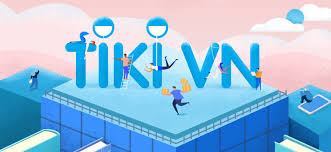

This notebook will guide you to use python function recursively to crawl main categories. For each main categories, it will start to crawl links for sub categories. Recursively, each sub categories have deeper levels of sub categories( Main -> level 2 -> level 3 -> level 4 -> ... ? ) = How deep can it go -> Inception!!!

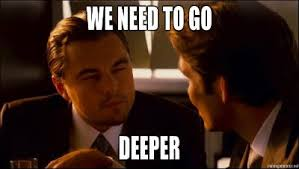

Since we don't know how many level of sub categories and how deep for each categories, we need to use recursion to solve this problem.

All of these category links will be saved in a SQLite database.
After crawling all categories (main and subs), you can use your previous weekly project function to crawl products for each of categories to get to get as many products as possible.

At the end of the day, this notebook only crawl links of categories. Therefore, crawling products is your task for the weekly project.

In [ ]:
!sudo apt update

In [ ]:
!sudo apt upgrade

In [ ]:
import selenium

In [ ]:
selenium.__version__

'3.141.0'

In [ ]:
webdriver.__version__

'3.14.1'

In [ ]:
!chromedriver --version

ChromeDriver 89.0.4389.90 (62eb262cdaae9ef819aadd778193781455ec7a49-refs/branch-heads/4389@{#1534})


In [ ]:
!sudo apt install sqlite3

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  sqlite3-doc
The following NEW packages will be installed:
  sqlite3
0 upgraded, 1 newly installed, 0 to remove and 31 not upgraded.
Need to get 752 kB of archives.
After this operation, 2,482 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 sqlite3 amd64 3.22.0-1ubuntu0.4 [752 kB]
Fetched 752 kB in 1s (1,059 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package sqlite3.
(Reading d

In [ ]:
# install selenium and other resources for crawling data
!pip install selenium
# install other resources for doing crawling
!sudo apt install chromium-chromedriver

Reading package lists... Done
Building dependency tree       
Reading state information... Done
chromium-chromedriver is already the newest version (89.0.4389.90-0ubuntu0.18.04.2).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.


In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from time import sleep
from random import randint
import json
import re
import time
import sqlite3

from selenium import webdriver
# Set driver for Chrome
options = webdriver.ChromeOptions()
options.add_argument('--headless') # since we run selenium on Google Colab so we don't want a chrome browser opens, so it will run in the background
options.add_argument('--no-sandbox')

In [ ]:
print(options.arguments)

['--headless', '--no-sandbox']


In [ ]:
def get_url(url):
    driver = webdriver.Chrome('chromedriver',options=options)        # Define the chrome drivers with setting options we define above    
    # we let selenium to wait for 30 seconds for all javascript script done before return the result of HTML
    driver.implicitly_wait(30) 
    driver.get(url)                                             # Open the browser again to get web page
    html_data = driver.page_source                                   # After driver.get() is done, you can get back HTML string by using .page_source
    driver.close()                                                   # Close the driver after retrieving the web page
    time.sleep(5)
    soup = BeautifulSoup(html_data, 'html.parser') 

    return soup

In [ ]:
def extract_tiki_info(url):
  """ Extract info from all products of a specfic category on Tiki website
      Input: url
      Output: info of products, saved as list of dictionary. If no products shown, return empty list.
  """
  data = []
  index = 1
  soup = get_url(url)

  # FIND ALL PRODUCT ITEMS
  products = soup.find_all('a', {'class':'product-item'})
  all_script = soup.find_all('script', {'type':'application/ld+json'})
  print("BATCH SIZE:", len(products))

  if (soup.find('div', {'class':'style__StyledNotFoundProductView-sc-1uz0b49-0'})):
    print("END PAGE")
  elif len(products):
    # EXTRACT INFO TO DICTIONARY
    for i in products: 
      d = {'name':'','price':'','product_url':'','image':'', 'product_sku':'',
           'tiki_now':'','freeship':'','review':'','rating':'','under_price':'',
           'discount':'','installment':'','gift':''}
      
      try:
        d['name']         = i.find('div',{'class' : 'name'}).text
        d['price']        = int(re.sub('[. ₫]','', i.find('div',{'class':'price-discount__price'}).text))
        d['product_url']  = 'https://tiki.vn' + i['href'] 
        thumbnail         = i.find('div',{'class':'thumbnail'})
        d['image']        = thumbnail.img['src']        
        d['tiki_now']     = bool(i.find('div',{'class':'badge-service'}).find('div',{'class':'item'})) 
        d['freeship']     = bool(i.find('div',{'class':'badge-top'}).text == "Freeship")
        
        if i.find('div',{'class':'review'}):
          d['review']     = int(i.find('div',{'class':'review'}).text.strip('(').strip(')'))
        else:
          d['review'] = "N/A"
        
        d['under_price']  = bool(i.find('div',{'class':'badge-under-price'}).find('div',{'class':'item'}))

        if i.find('div', {'class':'price-discount__discount'}):
          d['discount']   = int(re.sub('[-%]','', i.find('div',{'class':'price-discount__discount'}).text))
        else:
          d['discount']   = "N/A"
        
        d['installment']  = bool(i.find('div',{'class':'badge-benefits'}).img)
        d['gift']         = bool(i.find('div',{'class':'freegift-list'}))

        script = all_script[index]
        dict_content = json.loads(script.text)
        d['product_sku']  = dict_content['sku']
        
        if 'aggregateRating' in dict_content:
          d['rating']     = float(dict_content['aggregateRating']['ratingValue'])
        else:
          d['rating']     = "N/A"

      except Exception as e:
        print(e)

      index += 1
      data.append(d)
        
  return data

In [ ]:
def scrape_tiki(base_url):
  result = []
  page_number = 1
  main, opt = base_url.split('?')
  
  while True:
    page = f'?page={page_number}&'
    url = main+page+opt
    print("url =", url)
    data = extract_tiki_info(url)
    if len(data)>0:
      result.extend(data)
    else:
      break
    if page_number == 2:
      break
    page_number += 1
    sleep(randint(1,2))

  print("****TOTAL = ",len(result))

  items = pd.DataFrame(data = result, columns = result[0].keys())
  items.to_csv("/content/gdrive/MyDrive/result2.csv", index=False)

# Function to do CRUD (create/ read/ update/ delete) on database

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
conn = sqlite3.connect('/content/gdrive/MyDrive/tiki_tan2.db')
cur = conn.cursor()

In [ ]:
# Create table categories in the database using a function
def create_categories_table():
    query = """
        CREATE TABLE IF NOT EXISTS categories (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            name VARCHAR(255),
            url TEXT, 
            parent_id INTEGER, 
            create_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
        )
    """
    try:
        cur.execute(query)
        conn.commit()
    except Exception as err:
        print('ERROR BY CREATE TABLE', err)

def select_query(query,conn=conn):
    print(hex(id(conn)))
    return pd.read_sql_query(query, conn)

def delete_categories_table() :
    cur.execute('DROP TABLE categories;')
    conn.commit()

In [ ]:
select_query('SELECT * FROM sqlite_master WHERE type = "table"')

In [ ]:
# create_categories_table()

In [ ]:
select_query('SELECT * FROM categories')

In [ ]:
select_query('SELECT * FROM products')

# OOP to do CRUD (create/ read/ update/ delete) on database

In [ ]:
# Instead of using a function to do CRUD on database,
# creating a class Category is preferred
# attributes: name, url, parent_id
# instance method: save_into_db()
class Category:
    def __init__(self, name, url, parent_id=None, cat_id=None):
        self.cat_id = cat_id
        self.name = name
        self.url = url
        self.parent_id = parent_id

    def __repr__(self):
        return f"ID: {self.cat_id}, Name: {self.name}, URL: {self.url}, Parent: {self.parent_id}"

    def save_into_db(self):
        query = """
            INSERT INTO categories (name, url, parent_id)
            VALUES (?, ?, ?);
        """
        val = (self.name, self.url, self.parent_id)
        try:
            cur.execute(query, val)
            self.cat_id = cur.lastrowid
            conn.commit()
        except Exception as err:
            print('ERROR BY INSERT:', err)


# Get main categories

In [ ]:
# empty our category set
CATEGORY_SET = set()

main_categories = [{'Name': 'Điện Thoại - Máy Tính Bảng', 'URL': 'https://tiki.vn/dien-thoai-may-tinh-bang/c1789?src=c.1789.hamburger_menu_fly_out_banner'},
{'Name': 'Điện Tử - Điện Lạnh', 'URL': 'https://tiki.vn/tivi-thiet-bi-nghe-nhin/c4221?src=c.4221.hamburger_menu_fly_out_banner'}, 
{'Name': 'Phụ Kiện - Thiết Bị Số', 'URL': 'https://tiki.vn/thiet-bi-kts-phu-kien-so/c1815?src=c.1815.hamburger_menu_fly_out_banner'},
{'Name': 'Laptop - Thiết bị IT', 'URL': 'https://tiki.vn/laptop-may-vi-tinh/c1846?src=c.1846.hamburger_menu_fly_out_banner'},
{'Name': 'Máy Ảnh - Quay Phim', 'URL': 'https://tiki.vn/may-anh/c1801?src=c.1801.hamburger_menu_fly_out_banner'}, 
{'Name': 'Điện Gia Dụng', 'URL': 'https://tiki.vn/dien-gia-dung/c1882?src=c.1882.hamburger_menu_fly_out_banner'}, 
{'Name': 'Nhà Cửa Đời Sống', 'URL': 'https://tiki.vn/nha-cua-doi-song/c1883?src=c.1883.hamburger_menu_fly_out_banner'}, 
{'Name': 'Hàng Tiêu Dùng - Thực Phẩm', 'URL': 'https://tiki.vn/bach-hoa-online/c4384?src=c.4384.hamburger_menu_fly_out_banner'}, 
{'Name': 'Đồ chơi, Mẹ & Bé', 'URL': 'https://tiki.vn/me-va-be/c2549?src=c.2549.hamburger_menu_fly_out_banner'}, 
{'Name': 'Làm Đẹp - Sức Khỏe', 'URL': 'https://tiki.vn/lam-dep-suc-khoe/c1520?src=c.1520.hamburger_menu_fly_out_banner'},
{'Name': 'Thể Thao - Dã Ngoại', 'URL': 'https://tiki.vn/the-thao/c1975?src=c.1975.hamburger_menu_fly_out_banner'},
{'Name': 'Xe Máy, Ô tô, Xe Đạp', 'URL': 'https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger_menu_fly_out_banner'},
{'Name': 'Hàng quốc tế', 'URL': 'https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner'}, 
{'Name': 'Sách, VPP & Quà Tặng', 'URL': 'https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner'}, 
{'Name': 'Voucher - Dịch Vụ - Thẻ Cào', 'URL': 'https://tiki.vn/voucher-dich-vu/c11312?src=c.11312.hamburger_menu_fly_out_banner'}]

In [ ]:
def can_add_to_cat_set(cat_name,save=False):
  if cat_name not in CATEGORY_SET:
    if save:
      CATEGORY_SET.add(cat_name)
      print(f'Added "{cat_name}" to CATEGORY_SET')
    return True
  return False

In [ ]:
def get_main_category(main_categories,save_db=False):
    result=[]
    for i in main_categories:
        _=can_add_to_cat_set(i['Name'],save_db)

        main_cat = Category(i['Name'],i['URL'])
        if save_db:
            main_cat.save_into_db()
        result.append(main_cat)
    return result

In [ ]:
# main_cat_objs = get_main_category(main_categories,save_db=False)
# main_cat_objs

In [ ]:
select_query('SELECT * FROM CATEGORIES')

# Get sub categories

In [ ]:
# get_sub_categories() given a parent category
def get_sub_categories(parent_category, save_db=False):
    parent_url = parent_category.url
    result = []

    try:
        soup = get_url(parent_url)
        with open('test','w') as checksoup:
            checksoup.write(soup.prettify())
        for a in soup.find_all('a', {'class':'item item--category'}):
            name = a.text.strip()
            if can_add_to_cat_set(name,save_db): 
                sub_url = a['href']
                cat = Category(name, sub_url, parent_category.cat_id) # we now have parent_id, which is cat_id of parent category
                if save_db:
                  cat.save_into_db()
                result.append(cat)
    except Exception as err:
        print('ERROR IN GETTING SUB CATEGORIES:', err)
    return result

# Put everything together

In [ ]:
# get_all_categories() given a list of main categories (This is a recursion function)
# def get_all_categories(categories,save_db):
#     # if I reach the last possible category, I need to stop
#     if len(categories) == 0:
#         return      
#     for cat in categories:
#         print(f'Getting {cat} sub-categories...')
#         sub_categories = get_sub_categories(cat, save_db=save_db)
#         print(f'Finished! {cat.name} has {len(sub_categories)} sub-categories')
#         get_all_categories(sub_categories,save_db=save_db)

In [ ]:
def get_all_categories(categories,save_db):
    categories = categories.copy()
    while len(categories):
        cat_to_crawl = categories[0]
        print(f'Getting {cat_to_crawl} sub-categories...')
        sub_categories = get_sub_categories(cat_to_crawl, save_db=save_db)
        print(f'Finished! {cat_to_crawl.name} has {len(sub_categories)} sub-categories')
        categories+=sub_categories
        del categories[0]

In [ ]:
# main_cat_objs = get_main_category(main_categories,save_db=False)
# main_cat_objs

In [ ]:
# get_all_categories(main_cat_objs,save_db=True)

In [ ]:
select_query('SELECT COUNT(*) FROM categories')

In [ ]:
select_query('SELECT * FROM categories ORDER BY ID DESC LIMIT 5')

# Find lowest categories

In [ ]:
lowest_cats = select_query('''
  SELECT DISTINCT id, url
  FROM categories 
    WHERE id IN (
        SELECT DISTINCT id 
        FROM categories 
        
        EXCEPT 
        
        SELECT DISTINCT parent_id 
        FROM categories
        ) 
    ORDER BY id DESC ''')
lowest_cats

In [ ]:
lowest_cats.iloc[1151,:]

In [ ]:
select_query('''
    SELECT COUNT(*) 
    FROM (
        SELECT * 
        FROM categories 
            WHERE id IN (
                SELECT DISTINCT id 
                FROM categories 
                
                EXCEPT 
                
                SELECT DISTINCT parent_id 
                FROM categories
                )
        )
''')

,COUNT(*)
0,2302


# Class Product

In [ ]:
# Create table products in the database using a function
def create_products_table():
    query = """
        CREATE TABLE IF NOT EXISTS products (
            product_sku INTERGER PRIMARY KEY,
            name TEXT,
            price INTEGER,
            category_id INTEGER,
            product_url TEXT,
            image TEXT,
            tiki_now INTEGER,
            freeship INTEGER,
            review INTEGER,
            rating REAL,
            under_price INTEGER,
            discount INTEGER,
            installment INTEGER, 
            gift INTEGER,
            create_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
        )
    """
    try:
        cur.execute(query)
        conn.commit()
    except Exception as err:
        print('ERROR BY CREATE TABLE', err)

In [ ]:
def delete_products_table() :
    cur.execute('DROP TABLE products;')
    conn.commit()

In [ ]:
class Product():
    def __init__(self, product, cat_id ) :
        # because extract_tiki_info return a dictionary, for each product, containing all product information
        # so the type of input arguments when creating Product instance is dictionary
        info = ['name','price''product_url','image', 'product_sku',
               'tiki_now','freeship','review','rating','under_price',
               'discount','installment','gift']
        self.name = product['name']
        self.price = int(product['price'])
        self.product_url = product['product_url']
        self.image = product['image']
        self.product_sku = int(product['product_sku'])
        self.tiki_now = int(product['tiki_now'])
        self.freeship = int(product['freeship'])
        self.review = float(product['review'])
        self.rating = float(product['rating'])
        self.under_price = int(product['under_price'])
        self.discount = float(product['discount'])
        self.installment = int(product['installment'])
        self.gift = int(product['gift'])
        self.cat_id = int(cat_id)
    
    def __repr__(self) :
        return f'SKU: {self.product_sku}\t Name: {self.name[:20]}...\t Price: {self.price} VND'

    def save_into_db(self):
        query = """
            INSERT INTO products (
                product_sku, name,
                price, category_id,
                product_url, image,
                tiki_now, freeship,
                review, rating,
                under_price, discount,
                installment, gift)
            VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?);
        """
        val = (self.product_sku, self.name, 
                self.price, self.cat_id,
                self.product_url, self.image,
                self.tiki_now, self.freeship,
                self.review, self.rating,
                self.under_price, self.discount,
                self.installment, self.gift)
        try:
            cur.execute(query, val)
            conn.commit()
        except Exception as err:
            print('ERROR BY INSERT:', err, self.product_sku)

# Scraping all product of lowest categories

In [ ]:
select_query('SELECT * FROM sqlite_master WHERE type = "table"')

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,3,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,categories,categories,2,CREATE TABLE categories (\n id INTE...
2,table,products,products,97,CREATE TABLE products (\n product_s...


In [ ]:
delete_products_table()

In [ ]:
create_products_table()
select_query('SELECT * FROM products')

,product_sku,name,price,category_id,product_url,image,tiki_now,freeship,review,rating,under_price,discount,installment,gift,create_at


In [ ]:
cur.lastrowid

0

## Scraping lowest categories

In [ ]:
number_catagory = int(lowest_cats.shape[0]/2)
last_row_id = 0
for i in range(number_catagory,len(lowest_cats)):
  row = lowest_cats.iloc[i,:]
  category_id = row['id']
  cat_url = row['url']
  scrape_tiki(cat_url)
  with open('/content/gdrive/MyDrive/result2.csv','r') as dataFile :
    data = pd.read_csv(dataFile)
    # print(type(data))
    for n in range(len(data)):
      # print(data.iloc[n,:])
      item = Product(data.iloc[n,:],category_id)
      item.save_into_db()
    print(f'FINISH SCRAPING CATEGORY ID: {category_id}\t {cur.lastrowid - last_row_id} PRODUCTS ADDED\t LAST-CHECKED PRODUCT ID: {data.iloc[-1,:]["product_sku"]}')  
    last_row_id = cur.lastrowid
  # last_product_sku = cur.execute(f'SELECT rowid, product_sku FROM products WHERE rowid = {cur.lastrowid}').fetchone()[-1]
  # print(f'FINISH SCRAPING CATEGORY ID: {category_id}\t LAST PRODUCT ID: {last_product_sku}')

Streaming output truncated to the last 5000 lines.
ERROR BY INSERT: UNIQUE constraint failed: products.product_sku 1968930007492
ERROR BY INSERT: UNIQUE constraint failed: products.product_sku 9448668102789
ERROR BY INSERT: UNIQUE constraint failed: products.product_sku 6770091827506
ERROR BY INSERT: UNIQUE constraint failed: products.product_sku 2696824192212
ERROR BY INSERT: UNIQUE constraint failed: products.product_sku 6003582165512
ERROR BY INSERT: UNIQUE constraint failed: products.product_sku 4100400393583
ERROR BY INSERT: UNIQUE constraint failed: products.product_sku 4184524016191
ERROR BY INSERT: UNIQUE constraint failed: products.product_sku 1613782009117
ERROR BY INSERT: UNIQUE constraint failed: products.product_sku 7137624682961
ERROR BY INSERT: UNIQUE constraint failed: products.product_sku 4508682248711
ERROR BY INSERT: UNIQUE constraint failed: products.product_sku 8028124647330
ERROR BY INSERT: UNIQUE constraint failed: products.product_sku 2909432199574
ERROR BY INSE

IndexError: ignored

In [ ]:
select_query('SELECT * FROM products ORDER BY category_id')

,product_sku,name,price,category_id,product_url,image,tiki_now,freeship,review,rating,under_price,discount,installment,gift,create_at
0,5009964552995,Quạt đứng Toshiba F-LSD10(W)VN - Hàng chính hãng,1469000,1334,https://tiki.vn/quat-dung-toshiba-f-lsd10-w-vn...,https://salt.tikicdn.com/cache/280x280/ts/prod...,1,0,377.0,4.6,0,18.0,0,0,2021-04-11 10:55:35
1,9443464073141,Quạt Đứng Toshiba F-LSD10(H)VN - Xám - Hàng c...,1468900,1334,https://tiki.vn/quat-dung-toshiba-f-lsd10-h-vn...,https://salt.tikicdn.com/cache/280x280/ts/prod...,1,0,183.0,4.5,0,18.0,0,0,2021-04-11 10:55:35
2,5156564620194,Quạt Đứng Toshiba F- LSA20(W)VN (60W) - Trắng ...,998400,1334,https://tiki.vn/quat-dung-toshiba-f-lsa20-w-vn...,https://salt.tikicdn.com/cache/280x280/ts/prod...,1,0,177.0,4.7,0,20.0,0,0,2021-04-11 10:55:36
3,7916728988441,Quạt đứng Toshiba F-LSA10(H)VN (60W) - Xám - H...,799100,1334,https://tiki.vn/quat-dung-toshiba-f-lsa10-h-vn...,https://salt.tikicdn.com/cache/280x280/ts/prod...,1,0,124.0,4.5,0,19.0,0,0,2021-04-11 10:55:36
4,6937841624181,Quạt Điện Đứng 7 cánh Senko LTS1636 - Giao Màu...,388000,1334,https://tiki.vn/quat-dien-dung-7-canh-senko-lt...,https://salt.tikicdn.com/cache/280x280/ts/prod...,0,0,NaN,NaN,0,22.0,0,0,2021-04-11 10:55:36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12968,2209984336602,Đệm lót ghế văn phòng hạt gỗ nhãn 12ly (hình t...,87000,1566,https://tiki.vn/dem-lot-ghe-van-phong-hat-go-n...,https://salt.tikicdn.com/cache/280x280/ts/prod...,1,0,7.0,4.6,0,75.0,0,0,2021-04-11 08:25:59
12969,1968732296643,Ghế xoay văn phòng 301 thiết kế hiện đại,535000,1566,https://tiki.vn/ghe-xoay-van-phong-301-thiet-k...,https://salt.tikicdn.com/cache/280x280/ts/prod...,1,0,NaN,NaN,0,14.0,0,0,2021-04-11 08:25:59
12970,2020351096253,"Ghế xoay, Ghế văn phòng, Ghế làm việc, ghế xoa...",1599000,1566,https://tiki.vn/ghe-xoay-ghe-van-phong-ghe-lam...,https://salt.tikicdn.com/cache/280x280/ts/prod...,0,0,NaN,NaN,0,35.0,0,0,2021-04-11 08:25:59
12971,5402715430038,Ghế văn phòng - Ghế giám đốc - Ghế da cao cấp ...,2159000,1566,https://tiki.vn/ghe-van-phong-ghe-giam-doc-ghe...,https://salt.tikicdn.com/cache/280x280/ts/prod...,0,0,2.0,NaN,0,38.0,0,0,2021-04-11 08:25:59


# UNION 2 products table in 2 separate databases

In [ ]:
# close connection and cursor to the database
cur.close()
conn.close()

In [ ]:
conn = sqlite3.connect('/content/gdrive/MyDrive/tiki_tan2.db')
cur = conn.cursor()

In [ ]:
cur.execute('ATTACH DATABASE "/content/gdrive/MyDrive/tiki_ha.db" AS tiki2')

In [ ]:
select_query('SELECT * FROM sqlite_master', conn)

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,3,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,categories,categories,2,CREATE TABLE categories (\n id INTE...
2,table,products,products,97,CREATE TABLE products (\n product_s...
3,index,sqlite_autoindex_products_1,products,1109,None


In [ ]:
# tiki_tan3.db and tiki_ha.db
select_query('''
    SELECT *
    FROM main.products
      
    UNION

    SELECT * 
    FROM tiki2.products
    ''', conn)

,product_sku,name,price,category_id,product_url,image,tiki_now,freeship,review,rating,under_price,discount,installment,gift,create_at
0,1000015575240,Combo 10 Quần Đùi Cho Bé Trai Hàng Xuất Chất Đẹp,139000,2534,https://tiki.vn/combo-10-quan-dui-cho-be-trai-...,https://salt.tikicdn.com/cache/280x280/ts/prod...,1,0,7.0,4.1,0,93.0,0,0,2021-04-11 01:56:01
1,1000159457273,Bình phong khung gỗ tranh XUÂN-HẠ-THU-ĐÔNG 180...,3900000,1548,https://tiki.vn/binh-phong-khung-go-tranh-xuan...,https://salt.tikicdn.com/cache/280x280/ts/prod...,0,0,NaN,NaN,0,20.0,1,0,2021-04-11 08:34:41
2,1000410359599,i-Learn Smart Maths Grade 5 Student's Book Par...,134100,2757,https://tiki.vn/i-learn-smart-maths-grade-5-st...,https://salt.tikicdn.com/cache/280x280/ts/prod...,1,0,NaN,NaN,0,10.0,0,0,2021-04-11 00:06:43
3,1000834121185,Bếp hồng ngoại Arber AB 263 - Hàng chính hãng,1950000,2498,https://tiki.vn/bep-hong-ngoai-arber-ab-263-ha...,https://salt.tikicdn.com/cache/280x280/ts/prod...,0,0,NaN,NaN,0,NaN,0,0,2021-04-11 02:23:51
4,1000933402062,Khung võng xếp Sao Mai thép cỡ lớn,395000,1437,https://tiki.vn/khung-vong-xep-sao-mai-thep-co...,https://salt.tikicdn.com/cache/280x280/ts/prod...,0,0,NaN,NaN,0,28.0,0,0,2021-04-11 09:42:48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29906,9998572918414,Bấm móng tay cao cấp Nhật KAI-Type101 KE0106,369000,2637,https://tiki.vn/bam-mong-tay-cao-cap-nhat-kai-...,https://salt.tikicdn.com/cache/280x280/ts/prod...,0,0,NaN,NaN,0,NaN,0,0,2021-04-11 01:00:20
29907,9998921838066,Túi đựng thực phẩm tự hủy sinh học An Lành 30x...,81900,1468,https://tiki.vn/tui-dung-thuc-pham-tu-huy-sinh...,https://salt.tikicdn.com/cache/280x280/ts/prod...,0,0,NaN,NaN,0,42.0,0,0,2021-04-11 09:22:57
29908,9999020293398,Rèm Cửa Nhà Tắm Decor Cá Tính,55000,1536,https://tiki.vn/rem-cua-nha-tam-decor-ca-tinh-...,https://salt.tikicdn.com/cache/280x280/ts/prod...,0,0,7.0,3.7,0,63.0,0,0,2021-04-11 08:42:24
29909,9999465539279,Sofa Bed Vải Bố Màu Nâu Sang Trọng_Chân Inox C...,2040000,1539,https://tiki.vn/sofa-bed-vai-bo-mau-nau-sang-t...,https://salt.tikicdn.com/cache/280x280/ts/prod...,0,0,NaN,NaN,0,57.0,0,0,2021-04-11 08:40:26


# SQL questions

### What is the most expensive item for each categories ?

In [ ]:
select_query('''
WITH all_products AS (
  SELECT *
  FROM main.products
      
  UNION

  SELECT * 
  FROM tiki2.products
)
SELECT category_id, product_sku, name, MAX(price)
FROM all_products
  GROUP BY category_id
''', conn)

,category_id,product_sku,name,MAX(price)
0,1334,3228413496440,Quạt Đứng Panasonic F-409KB-Hàng Chính Hãng,3680000
1,1335,3348274578250,"Quạt sạc AC ARF01D163YL (25W), cánh 16 inch - ...",2864900
2,1336,7649891935201,Quạt phun sương công nghiệp Mitsuta DB-26CF08 ...,3590000
3,1337,2153419327416,Quạt bàn kiểu cổ Kim Thuận Phong BC301 (Đen) (...,5520000
4,1338,1194727748488,QUẠT LỬNG N30NH(BR)- ĐỒNG (KDK),3782033
...,...,...,...,...
521,2775,8709816597934,Phấn phủ bắt sáng Thalissi Mosaico Lightening,3220000
522,2776,7797031178886,Tinh Chất Ngọc Trai Nguyên Chất Nuôi Dưỡng Làn...,1909000
523,2777,1337200648176,Chì kẻ mắt/mày không chì hữu cơ Juice Beauty P...,888000
524,2778,9599110513940,Serum Dưỡng Dài Và Dày Mi VIVA LASH Eyelash Co...,1800000


### Which catogory contains the most items?

In [ ]:
# 0x7f4a3919e2d0
# 0x7f4a378fdc70

In [ ]:
select_query('''
WITH all_products AS (
  SELECT *
  FROM main.products
      
  UNION

  SELECT * 
  FROM tiki2.products
)
SELECT category_id, categories.name, COUNT(product_sku) AS NumberOfProducts
FROM all_products
  JOIN categories 
    ON all_products.category_id = categories.id
  GROUP BY category_id
  ORDER BY NumberOfProducts DESC
''', conn)

0x7f4a378fdc70


,category_id,name,NumberOfProducts
0,1415,"Bộ chăn ga, ra, drap",120
1,2664,Phụ kiện ngoại thất khác,120
2,2651,Phụ kiện nội thất khác,117
3,2652,"Gối, đệm, ghế ô tô",113
4,1362,Tranh canvas,111
...,...,...,...
521,2700,Máy Tính Để Bàn,1
522,2760,High School: Grades 10 - 12,1
523,2764,TOEIC Books,1
524,2770,Teamwork,1


### Which category has the highest average reviews or ratings ...? 

In [ ]:
select_query('''
WITH all_products AS (
  SELECT *
  FROM main.products
      
  UNION

  SELECT * 
  FROM tiki2.products
)
SELECT category_id, categories.name, AVG(rating) AS AverageRating, AVG(review) AS AverageReviews
FROM all_products
  JOIN categories 
    ON all_products.category_id = categories.id
  GROUP BY category_id
  HAVING AverageRating NOT NULL
  ORDER BY AverageReviews DESC, AverageRating DESC
''', conn)

0x7f4a378fdc70


,category_id,name,AverageRating,AverageReviews
0,2488,Chuột Văn Phòng Không Dây,4.540909,156.583333
1,1467,"Cà men, hộp đựng cơm",4.554667,142.765432
2,2681,Bơm xe,4.050000,134.750000
3,1564,"Tủ, kệ sách",4.503030,101.157895
4,2612,"Sạch nhờn, ngừa mụn",4.668889,96.541667
...,...,...,...,...
471,2721,"Puzzles, games books",5.000000,1.480000
472,1560,Ghế trang điểm,4.000000,1.375000
473,2737,Everyday Feelings,4.500000,1.357143
474,2715,Nursery rhymes and rhyme books,4.700000,1.294118


### Which product has the highest number of reviews, what is its ratings ? 

In [ ]:
select_query('''
WITH all_products AS (
  SELECT *
  FROM main.products
      
  UNION

  SELECT * 
  FROM tiki2.products
),
tmp AS (
SELECT a.product_sku, a.name, c.name AS Category, MAX(review) AS MaxReview
FROM all_products AS a
  JOIN categories AS c
    ON a.category_id = c.id
  GROUP BY category_id
  ORDER BY MaxReview DESC
)
SELECT product_sku, tmp.name, Category, MaxReview, rating
FROM tmp
  JOIN all_products USING (product_sku)
''', conn)

0x7f4a378fdc70


,product_sku,name,Category,MaxReview,rating
0,6702966607906,Chuột Không Dây Logitech M331 Silent - Hàng Ch...,Chuột Văn Phòng Không Dây,4186.0,4.7
1,5700202968805,Hộp Hâm Nóng Arirang Life EL-ALS263 (Tím),Hộp hâm nóng,1544.0,4.5
2,5005787889454,Chuột Có Dây Logitech B100 - Hàng Chính Hãng,Chuột Văn Phòng Có Dây,1486.0,4.7
3,6461216496669,Kệ Sách Đa Tầng Để Sàn,"Tủ, kệ sách",1479.0,4.7
4,6805701692943,Bàn Phím Bluetooth Logitech K380 - Hàng Chính ...,Bàn Phím Văn Phòng Không Dây,1454.0,4.7
...,...,...,...,...,...
521,7869001197538,Roddy Learns A Lesson,Learning to Get Along,NaN,NaN
522,9780439773911,Folk and Fairy Tale Easy Readers (A Collection...,Toddler Tools,NaN,NaN
523,4563061835500,The Dynamics Of Writing Instruction: A Structu...,High School: Grades 10 - 12,NaN,NaN
524,1680040791626,Organize Your Team Today: The Mental Toughness...,Teamwork,NaN,NaN


### Which category has the most children ?

In [ ]:
select_query('''
WITH all_products AS (
  SELECT *
  FROM main.products
      
  UNION

  SELECT * 
  FROM tiki2.products
)
SELECT c1.id AS CategoryId, c1.name AS Name, COUNT(c2.parent_id) AS number_sub_categories
  FROM categories as c1
    JOIN categories as c2
      ON c1.id = c2.parent_id
    --WHERE c1.parent_id IS NULL
    GROUP BY c1.id
    ORDER BY number_sub_categories DESC
    LIMIT 10
''', conn)

0x7f4a378fdc70


,CategoryId,Name,number_sub_categories
0,59,Sửa chữa nhà cửa,30
1,138,Thiết Bị Số - Phụ Kiện Số,26
2,403,Phụ kiện nhà bếp,25
3,54,Đồ dùng nhà bếp,24
4,70,Nhạc cụ,24
5,150,Sách tiếng Việt,24
6,7,Nhà Cửa Đời Sống,21
7,65,Vật phẩm phong thủy,21
8,1021,Sách văn học,21
9,62,Ngoài trời & sân vườn,20


### What is the price range for each category ?

In [ ]:
select_query('''
WITH all_products AS (
  SELECT *
  FROM main.products
      
  UNION

  SELECT * 
  FROM tiki2.products
)

SELECT category_id, categories.name, MIN (price), MAX (price) 
FROM all_products
  JOIN categories 
    ON all_products.category_id = categories.id
  GROUP BY category_id
''', conn)

0x7f4a378fdc70


,category_id,name,MIN (price),MAX (price)
0,1334,Quạt Đứng,159000,3680000
1,1335,Quạt sạc,40000,2864900
2,1336,Quạt treo tường,249000,3590000
3,1337,Quạt bàn,48999,5520000
4,1338,Quạt lửng,299000,3782033
...,...,...,...,...
521,2775,Phấn nén,74500,3220000
522,2776,Phấn bột,32900,1909000
523,2777,Dạng bút,67000,888000
524,2778,Dạng nước,39000,1800000


## What is the best products for each category, in term of rating and reviews ?

In [ ]:
select_query('''

''', conn)

## Show me products that not only are the most discounted but also has free gifts for each category

In [ ]:
select_query('''
WITH all_products AS (
  SELECT *
  FROM main.products
      
  UNION

  SELECT * 
  FROM tiki2.products
)
SELECT product_sku, name, MAX(discount) AS Discount, gift
FROM all_products
  GROUP BY category_id
  HAVING gift = 1
  ORDER BY Discount DESC
''', conn)

0x7f4a378fdc70


,product_sku,name,Discount,gift
0,1913299304348,Bong bóng hình chữ số tráng nhôm kích cỡ 32 in...,86.0,1
1,5412450536315,Kệ Nhựa Để Đồ Đa Năng 3 Tầng Có Bánh Xe,82.0,1
2,6636200166815,My Pirate Poster Pack,82.0,1
3,9781788700597,"TheDadLab: 40 Quick, Fun and Easy Activities t...",79.0,1
4,3007716994019,Phấn Nước A'ERVEAL Double Lasting CC (Kèm Lõi ...,72.0,1
5,2677867688207,My Bag of Super Cool Activities,70.0,1
6,3459393397247,Usborne Card Games To Play,70.0,1
7,9781474921817,Usborne Donkeys,70.0,1
8,7535052364495,The Best Ever Baking Book,64.0,1
9,5260262167698,AdCombo 6 màu Chì Kẻ Mắt Shiny Water Proof Lon...,61.0,1
